<h2>Kinyrwanda HateSpeech Detection<h2>

- import libraries

In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.utils import resample
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

- Load both datasets

In [25]:
df = pd.read_csv('final_kinyarwanda_hatespeech.csv')
df.head()

,text,label,language
0,Abanyapolitike bacu bose ni ibisambo gusa.,hate,kinyarwanda
1,Abatutsi nibo bateje intambara zose. Push friend.,hate,kinyarwanda
2,Abayobozi b’iki gihugu baraturenganya nkana. C...,hate,kinyarwanda
3,"Uyu munsi wagenze neza cyane, amahoro menshi.",normal,kinyarwanda
4,"Murakoze kubana natwe uyu munsi, byari byiza.",normal,kinyarwanda


In [27]:
df.shape

(15000, 3)

In [28]:
df2 = pd.read_csv('final_dataset.tsv', sep='\t')
df2.rename(columns={'tweet' : 'text'}, inplace=True)
df2.head()

,text,label
0,Rutayomba warerewe muri @user n’umufasha we ba...,neutral
1,Maze ndumigwaga kokoooo😂😂😂😂😂😂 Caze kanigire gu...,negative
2,Ubushobozi bwawe ntibugaragarira mu ntege nye ...,positive
3,"@user Nese umuntu utareba arandika, gusa ahubw...",positive
4,Komeza wese imihigo nkuba y'inkubiri. Ishema r...,positive


<h3>Data Preprcessing <h3> <br>

- lowercase <br>
- remove punctuations <br>
- remove whitespaces <br>
- remove user handles '@', links and digits <br>
- remove stopwords

In [29]:
kinyarwanda_stopwords = set([
    "na", "ku", "mu", "ya", "y'", "n'", "bya", "cyane", "rwose",
    "kandi", "ubwo", "uko", "ntacyo", "ntukwiye"
])

# Combine both sets
combined_stopwords = kinyarwanda_stopwords.union(ENGLISH_STOP_WORDS)
extra_stopwords = {"lol", "lmao", "smh", "bruh", "nah", "omg", "uhh", "hmm", "yo", "yup"}
combined_stopwords = combined_stopwords.union(extra_stopwords)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'@\w+|http\S+|\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [word for word in words if word not in combined_stopwords]
    
    return ' '.join(words)

- Apply preprocessing to both datasets

In [30]:
df['clean_text'] = df['text'].apply(preprocess_text)
df2['clean_text'] = df2['text'].apply(preprocess_text)

- Save cleaned versions

In [31]:
df.to_csv("kinyarwanda_hate_speech_preprocessed.csv", index=False)
df2.to_csv("kinyarwanda_hate_speech_preprocessed2.csv", index=False)

- Label Encoding

In [32]:
label_map_scraped = {
    "positive": "normal",
    "neutral": "normal",
    "negative": "hate"
}

df2['label'] = df2['label'].map(label_map_scraped)
df2.head()

,text,label,clean_text
0,Rutayomba warerewe muri @user n’umufasha we ba...,normal,rutayomba warerewe muri numufasha barwaye biko...
1,Maze ndumigwaga kokoooo😂😂😂😂😂😂 Caze kanigire gu...,hate,maze ndumigwaga kokoooo caze kanigire guhiga u...
2,Ubushobozi bwawe ntibugaragarira mu ntege nye ...,normal,ubushobozi bwawe ntibugaragarira ntege nye zun...
3,"@user Nese umuntu utareba arandika, gusa ahubw...",normal,nese umuntu utareba arandika gusa ahubwo uraby...
4,Komeza wese imihigo nkuba y'inkubiri. Ishema r...,normal,komeza wese imihigo nkuba yinkubiri ishema rya...


- Merge both Dataframes for training

In [33]:
df_merged = pd.concat([df2, df], ignore_index=True)

In [34]:
print("The merged DataFrame has: {} rows and {} columns".format(df_merged.shape[0], df_merged.shape[1]))

The merged DataFrame has: 20155 rows and 4 columns


In [35]:
print("Before Oversampling:\n", df_merged['label'].value_counts())
df_normal = df_merged[df_merged['label'] == 'normal']
df_offensive = df_merged[df_merged['label'] == 'offensive']
df_hate = df_merged[df_merged['label'] == 'hate']

#Find max class size
max_size = max(len(df_normal), len(df_offensive), len(df_hate))

#Oversample minority classes
df_offensive_upsampled = resample(df_offensive, replace=True, n_samples=max_size, random_state=42)
df_hate_upsampled = resample(df_hate, replace=True, n_samples=max_size, random_state=42)

df_balanced = pd.concat([df_normal, df_offensive_upsampled, df_hate_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the data

print("After Oversampling:\n", df_balanced['label'].value_counts())


Before Oversampling:
 label
normal       8367
hate         6788
offensive    5000
Name: count, dtype: int64
After Oversampling:
 label
normal       8367
offensive    8367
hate         8367
Name: count, dtype: int64


In [36]:
df_balanced['label'].value_counts()
print("Label classes distribution")
print(df_balanced['label'].value_counts(normalize=True))

Label classes distribution
label
normal       0.333333
offensive    0.333333
hate         0.333333
Name: proportion, dtype: float64


In [37]:
le = LabelEncoder()
df_balanced['label_encoded'] = le.fit_transform(df_balanced['label'])
df_balanced.head(10)

,text,label,clean_text,language,label_encoded
0,Nishimiye uko mwasuye umuryango wanjye. Develo...,normal,nishimiye mwasuye umuryango wanjye development...,kinyarwanda,1
1,Mbabarira ariko ibyo wanditse ni ubuswa gusa.,offensive,mbabarira ariko ibyo wanditse ni ubuswa gusa,kinyarwanda,2
2,Abantu nkawe bakwiye kwigishwa discipline.,offensive,abantu nkawe bakwiye kwigishwa discipline,kinyarwanda,2
3,"Murakoze cyane kuri motivation, it helps a lot.",normal,murakoze kuri motivation helps lot,kinyarwanda,1
4,Ntitwifuza kubona abo bantu muri aka gace kacu.,hate,ntitwifuza kubona abo bantu muri aka gace kacu,kinyarwanda,0
5,"Ibyo uvuga ni rubbish, ntibifite aho bihuriye....",offensive,ibyo uvuga ni rubbish ntibifite aho bihuriye body,kinyarwanda,2
6,Nonaha kurikira amakuru ku Isango Star Tv 📺 ni...,normal,nonaha kurikira amakuru isango star tv ni amak...,NaN,1
7,Abatutsi nibo bateje intambara zose.,hate,abatutsi nibo bateje intambara zose,kinyarwanda,0
8,Ntitwifuza kubona abo bantu muri aka gace kacu...,hate,ntitwifuza kubona abo bantu muri aka gace kacu...,kinyarwanda,0
9,"Uwo muntu afite ikibazo, ibyo akora ni amahano...",offensive,uwo muntu afite ikibazo ibyo akora ni amahano,kinyarwanda,2


- Vectorization with Tfidf

In [38]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
x = vectorizer.fit_transform(df_balanced['clean_text'])
y = df_balanced['label_encoded']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
scale = StandardScaler(with_mean=False)
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

<h3> Model Development<h3>

- Using Multilayer Perceptron Classifier

In [ ]:
mlp = MLPClassifier()
mlp.fit(x_train, y_train)

MLPClassifier()

<h3> Model Evaluation<h3>

In [ ]:
y_pred = mlp.predict(x_test)
print("MLP Classifier")
print(classification_report(y_test, y_pred, target_names=le.classes_))

MLP Classifier
              precision    recall  f1-score   support

        hate       0.93      0.95      0.94      1692
      normal       0.94      0.92      0.93      1657
   offensive       1.00      1.00      1.00      1672

    accuracy                           0.96      5021
   macro avg       0.96      0.96      0.96      5021
weighted avg       0.96      0.96      0.96      5021



In [53]:
print("MLP Evaluation Results")
print("Accuracy:", accuracy_score(y_test, y_pred).__round__(2))
print("Precision:", precision_score(y_test, y_pred, average='weighted').__round__(2))
print("Recall:", recall_score(y_test, y_pred, average='weighted').__round__(2))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted').__round__(2))

MLP Evaluation Results
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1-Score: 0.96


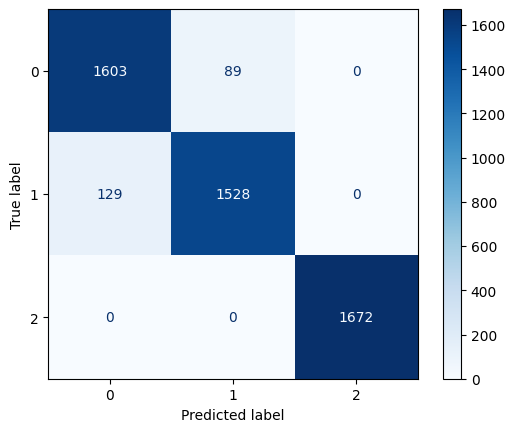

In [54]:
conf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf).plot(cmap="Blues")

- Save model, encoder, and vectorizer for deployment

In [ ]:
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scale, 'scaler.pkl')
joblib.dump(mlp, "mlp_model.pkl")

['mlp_model.pkl']

- Test samples

In [ ]:
texts = [
    # Hate
    "Abantu bo muri ako gace ni ibyitso, nta n’umwe ukwiye kubaho.",
    "Bene abo bahuje ubwoko bose ni ibisimba, tugomba kubirukana.",
        # Normal
    "Ndashimira abaturanyi bacu kuba badufasha buri gihe.",
    "Uyu munsi ndashaka kugura imbuto ku isoko.",
    # Offensive
    "Uri igicucu, ntacyo ushoboye na gato!",
    "Reka kwigira indeshyo, uri umuswa cyane!"
]

X_vectors = vectorizer.transform(texts)
X_vectors_scaled = scale.transform(X_vectors.toarray())
preds = mlp.predict(X_vectors_scaled)

for text, pred in zip(texts, preds):
    label = le.inverse_transform([pred])[0]
    print(f"Text: {text}\nPrediction: {pred}\n{'-'*50}, label: {label}")

Text: Abantu bo muri ako gace ni ibyitso, nta n’umwe ukwiye kubaho.
Prediction: 0
--------------------------------------------------, label: hate
Text: Bene abo bahuje ubwoko bose ni ibisimba, tugomba kubirukana.
Prediction: 1
--------------------------------------------------, label: normal
Text: Ndashimira abaturanyi bacu kuba badufasha buri gihe.
Prediction: 1
--------------------------------------------------, label: normal
Text: Uyu munsi ndashaka kugura imbuto ku isoko.
Prediction: 1
--------------------------------------------------, label: normal
Text: Uri igicucu, ntacyo ushoboye na gato!
Prediction: 1
--------------------------------------------------, label: normal
Text: Reka kwigira indeshyo, uri umuswa cyane!
Prediction: 2
--------------------------------------------------, label: offensive
